In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

### REFUGE: Generate OD coordinate labels from OD masks

Set the `data_root` to the folder containing the extracted REFUGE dataset folder:
- "data_root"
    - "REFUGE"
        - "Annotation-Training400"
        - ...

In [2]:
data_root = Path("../../fovea_detection/")

Then run the code to generate the OD coordinate labels from the OD masks and save them into `data_root`.

In [5]:
# Load OD masks (.bmp)
masks_paths = {
    "train_glaucoma": data_root.joinpath("REFUGE/Annotation-Training400/Annotation-Training400/Disc_Cup_Masks/Glaucoma"),
    "train_non-glaucoma": data_root.joinpath("REFUGE/Annotation-Training400/Annotation-Training400/Disc_Cup_Masks/Non-Glaucoma"),
    "val": data_root.joinpath("REFUGE/REFUGE-Validation400-GT/Disc_Cup_Masks")
}

mask_filenames = {
    "train_glaucoma": [],
    "train_non-glaucoma": [],
    "val": []
}
for k, v in masks_paths.items():
    mask_filenames[k] = [os.path.join(v, f) for f in os.listdir(v)]
    mask_filenames[k] = [f for f in mask_filenames[k] if f.endswith('.bmp')]

mask_filenames = mask_filenames["train_glaucoma"] + mask_filenames["train_non-glaucoma"] + mask_filenames["val"]
df = pd.DataFrame(mask_filenames, columns=["mask_path"])
df["ImgName"] = df["mask_path"].apply(lambda x: os.path.basename(x))
df

,mask_path,ImgName
0,../../fovea_detection/REFUGE/Annotation-Traini...,g0007.bmp
1,../../fovea_detection/REFUGE/Annotation-Traini...,g0018.bmp
2,../../fovea_detection/REFUGE/Annotation-Traini...,g0011.bmp
3,../../fovea_detection/REFUGE/Annotation-Traini...,g0033.bmp
4,../../fovea_detection/REFUGE/Annotation-Traini...,g0015.bmp
...,...,...
795,../../fovea_detection/REFUGE/REFUGE-Validation...,V0144.bmp
796,../../fovea_detection/REFUGE/REFUGE-Validation...,V0116.bmp
797,../../fovea_detection/REFUGE/REFUGE-Validation...,V0277.bmp
798,../../fovea_detection/REFUGE/REFUGE-Validation...,V0276.bmp


In [6]:
# Get images without valid OD mask. Skip, as there are none.
# masks = {f: plt.imread(f) for f in df["mask_path"]}

# no_od = []

# for f, mask in masks.items():
#     if np.all(mask == 255):
#         no_od.append(f)
# len(no_od) # > 0

0

In [7]:
# Get coordinates of OD by center of mass of mask in x and y
masks = {f: plt.imread(f) for f in df["mask_path"]}

for i, (f, mask) in enumerate(masks.items()):
    y, x = np.where(mask == 0)
    y = np.mean(y)
    x = np.mean(x)
    df.loc[df["mask_path"] == f, "OD_X"] = x
    df.loc[df["mask_path"] == f, "OD_Y"] = y

df['ImgName'] = df['ImgName'].apply(lambda x: x.replace('.bmp', '.jpg'))
df.sort_values('ImgName', inplace=True)

In [8]:
def get_img_path(row):
    f = row["ImgName"]
    if f.startswith("g"):
        folder = "REFUGE/REFUGE-Training400/Training400/Glaucoma"
    elif f.startswith("n"):
        folder = "REFUGE/REFUGE-Training400/Training400/Non-Glaucoma"
    elif f.startswith("V"):
        folder = "REFUGE/REFUGE-Validation400/REFUGE-Validation400"
    else:
        raise ValueError(f"Unknown prefix in {f}")

    return os.path.join(data_root, folder, f)

In [9]:
df["img_path"] = df.apply(get_img_path, axis=1)

In [10]:
df.sort_values(by="ImgName").to_excel(data_root.joinpath('REFUGE_OD_location.xlsx'), index=False)

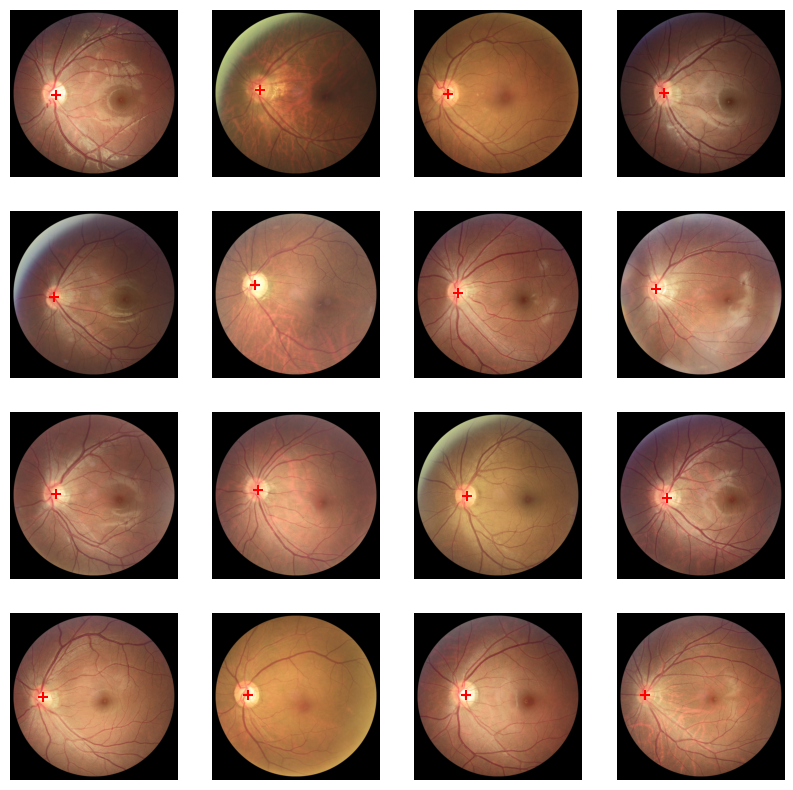

In [14]:
# Plot some imgs with the extracted OD centroid
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis('off')
    
    img = plt.imread(df.iloc[i]["img_path"])
    ax.imshow(img)
    ax.scatter(df.iloc[i]["OD_X"], df.iloc[i]["OD_Y"], c='r', s=50, marker='+')
    
plt.show()
plt.close()